In [3]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 5.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831127 sha256=7173bdba9b27eee85d67059234cfa884bcce11da7f12b6927d24f310658d80ec
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


In [4]:
from lightfm import LightFM

model = LightFM()
print(" LightFM installed and ready!")


 LightFM installed and ready!


In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import os

# Detect environment and set appropriate dataset path
try:
    # Check if running on Kaggle
    if '/kaggle/' in os.getcwd():
        dataset_path = "/kaggle/input/movielens"
        print("Running on Kaggle - using Kaggle dataset path")
    else:
        dataset_path = r"C:\Users\edwin\dataset movies\ml-100k"
        print("Running locally - using local dataset path")
except:
    # Default to local path if detection fails
    dataset_path = r"C:\Users\edwin\dataset movies\ml-100k"
    print("Environment detection failed - defaulting to local path")

print(f"Dataset path: {dataset_path}")

# Load u.data (ratings data)
# Columns: user_id, item_id, rating, timestamp
u_data = pd.read_csv(os.path.join(dataset_path, "u.data"), 
                     sep='\t', 
                     names=['user_id', 'item_id', 'rating', 'timestamp'],
                     header=None)

# Load u.user (user information)
# Columns: user_id, age, gender, occupation, zip_code
u_user = pd.read_csv(os.path.join(dataset_path, "u.user"), 
                     sep='|', 
                     names=['user_id', 'age', 'gender', 'occupation', 'zip_code'],
                     header=None)

# Load u.item (movie information)
# Columns: movie_id, title, release_date, video_release_date, imdb_url, and genre columns
item_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url'] + \
               [f'genre_{i}' for i in range(19)]  # 19 genre columns

u_item = pd.read_csv(os.path.join(dataset_path, "u.item"), 
                     sep='|', 
                     names=item_columns,
                     header=None,
                     encoding='latin1')  # Handle special characters

# Load u.genre (genre information)
# Columns: genre, genre_id
u_genre = pd.read_csv(os.path.join(dataset_path, "u.genre"), 
                      sep='|', 
                      names=['genre', 'genre_id'],
                      header=None)

print("Dataset loaded successfully!")
print(f"u.data shape: {u_data.shape}")
print(f"u.user shape: {u_user.shape}")
print(f"u.item shape: {u_item.shape}")
print(f"u.genre shape: {u_genre.shape}")

Running on Kaggle - using Kaggle dataset path
Dataset path: /kaggle/input/movielens
Dataset loaded successfully!
u.data shape: (100000, 4)
u.user shape: (943, 5)
u.item shape: (1682, 24)
u.genre shape: (19, 2)


Creating visualizations for u.data (Ratings)...
Creating visualizations for u.user (Users)...
Creating visualizations for u.item (Movies)...
Creating combined analysis visualizations...


/tmp/ipykernel_37/343793773.py:122: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_avg = user_age_ratings.groupby('age_group')['rating'].mean()
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


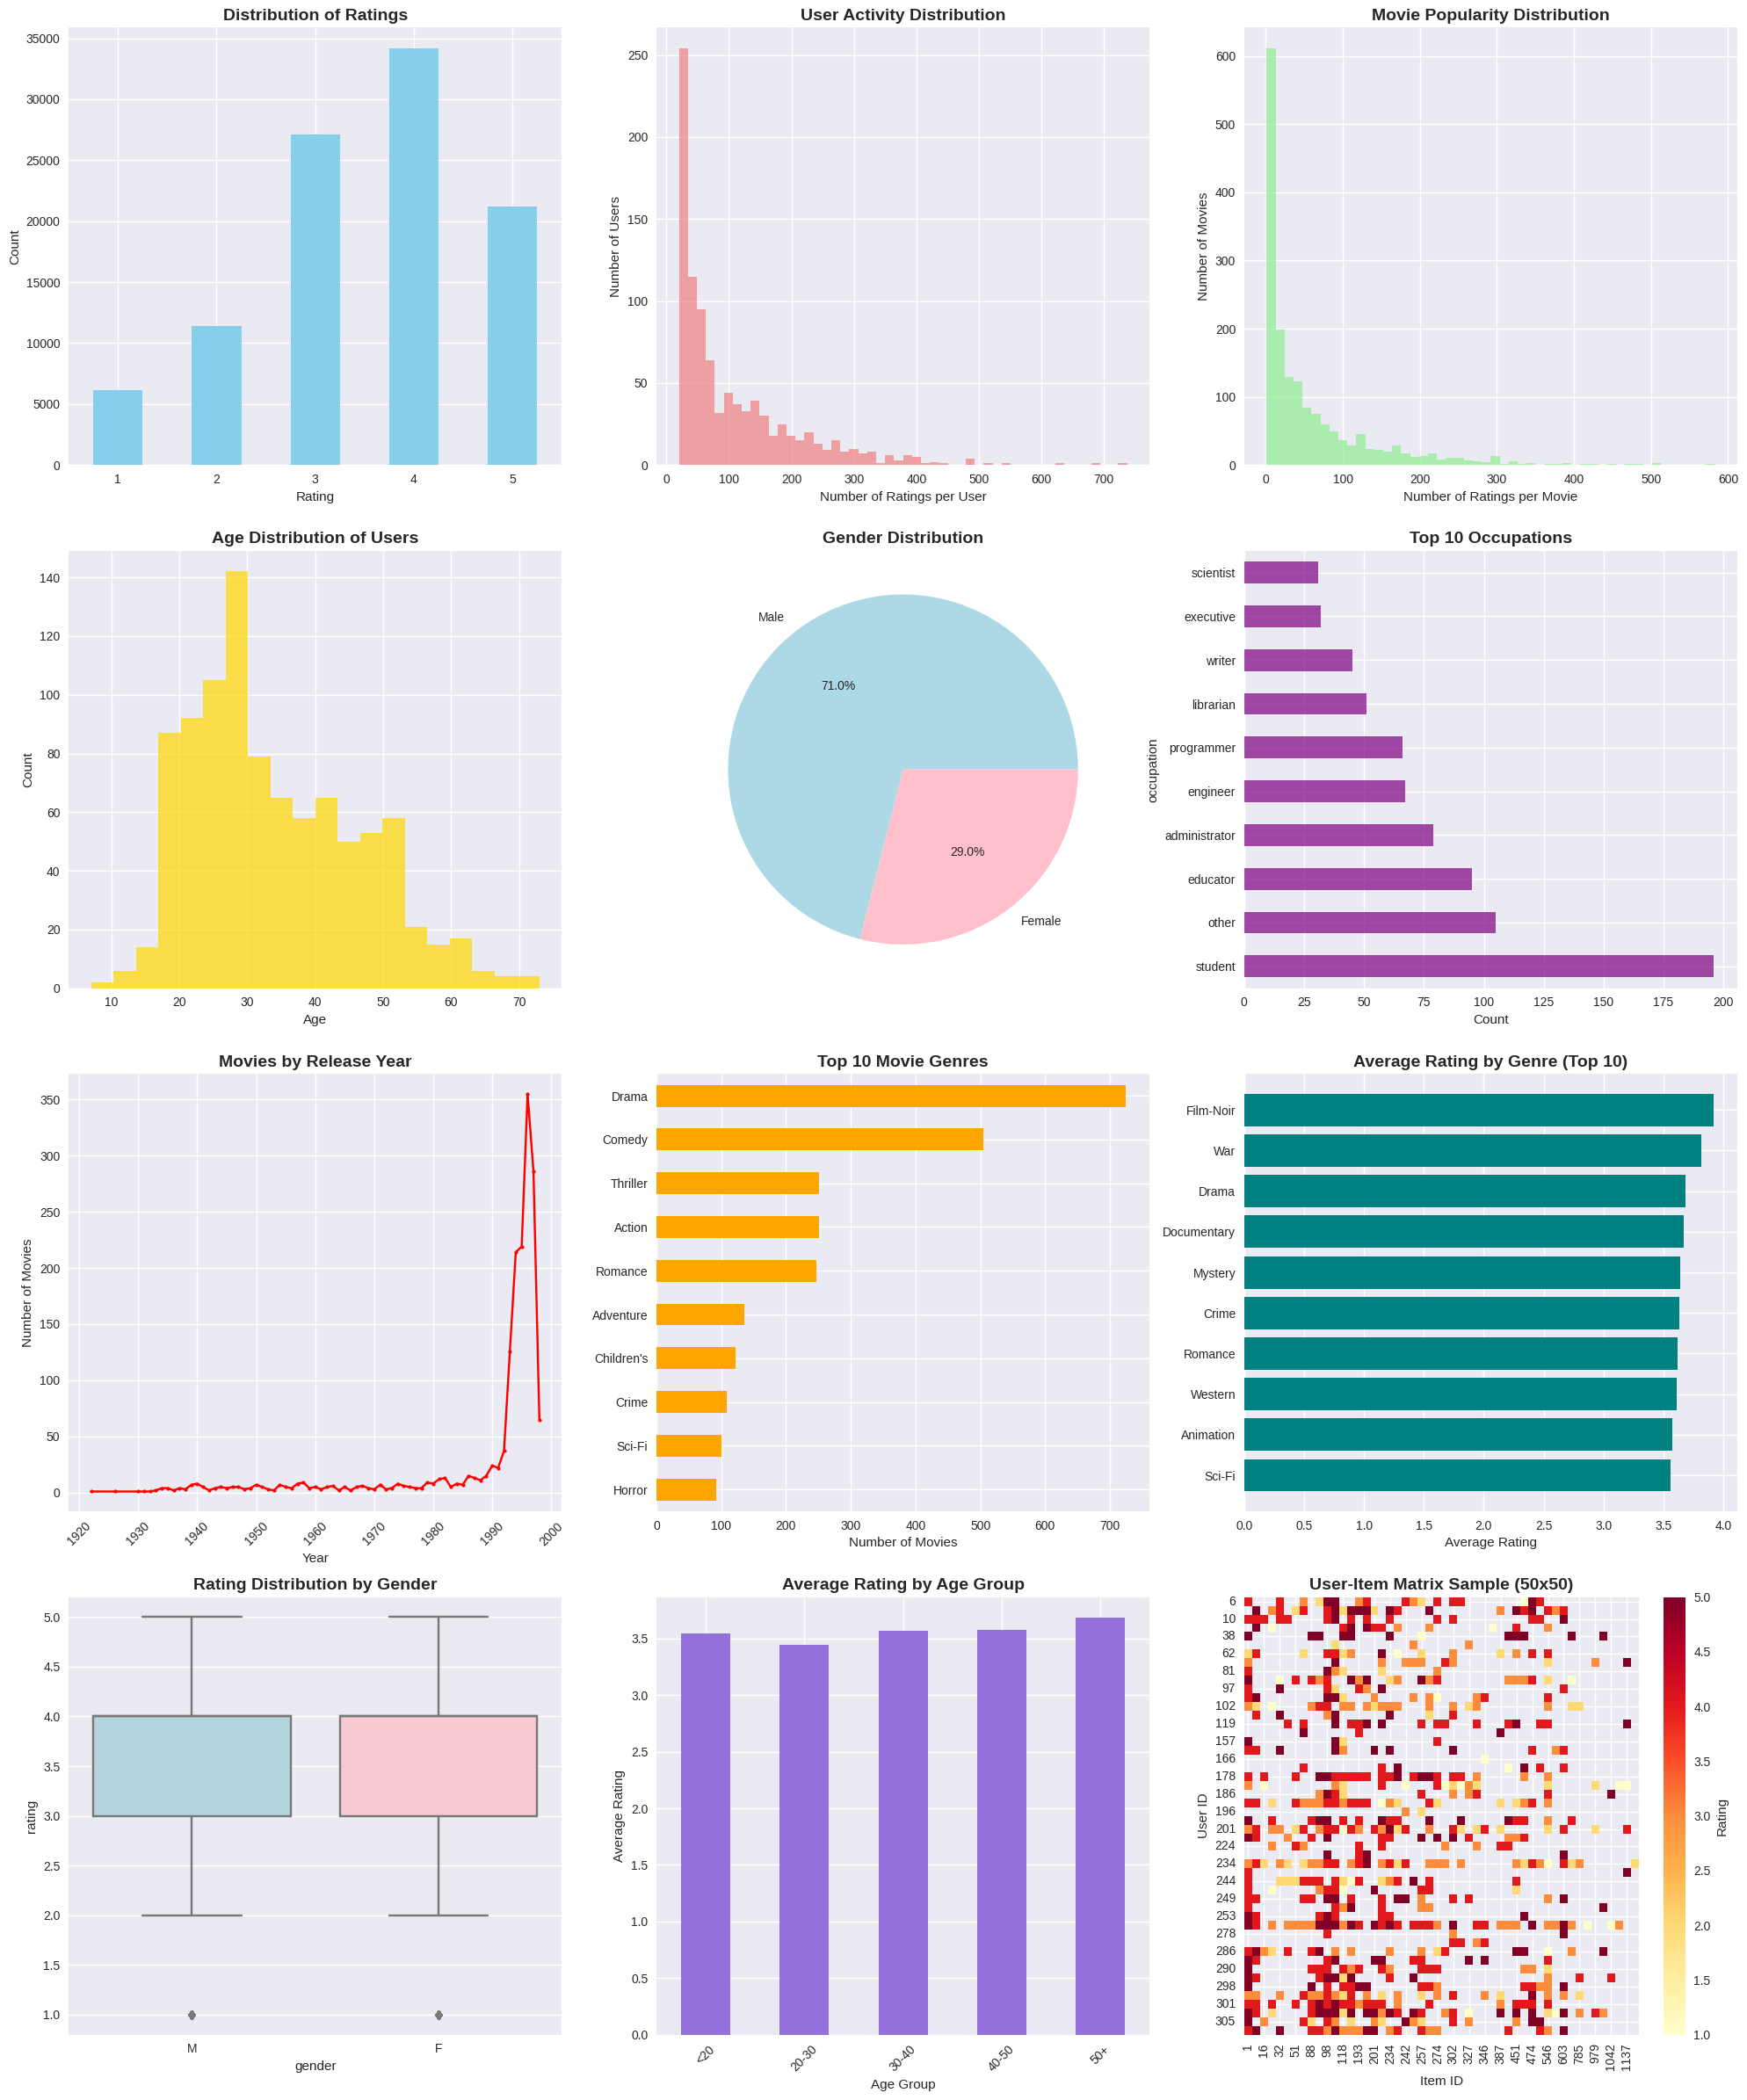


DATASET SUMMARY STATISTICS
Total ratings: 100,000
Total users: 943
Total movies: 1,682
Total genres: 19
Data sparsity: 93.70%
Average rating: 3.53
Rating std dev: 1.13
Most active user rated 737 movies
Most popular movie has 583 ratings


In [5]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create a large figure with subplots
fig = plt.figure(figsize=(20, 24))

# 1. RATINGS DATA VISUALIZATIONS
print("Creating visualizations for u.data (Ratings)...")

# Rating distribution
plt.subplot(4, 3, 1)
u_data['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Ratings', fontsize=14, fontweight='bold')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)

# User activity (number of ratings per user)
plt.subplot(4, 3, 2)
user_ratings = u_data['user_id'].value_counts()
plt.hist(user_ratings, bins=50, color='lightcoral', alpha=0.7)
plt.title('User Activity Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Number of Users')

# Movie popularity (number of ratings per movie)
plt.subplot(4, 3, 3)
movie_ratings = u_data['item_id'].value_counts()
plt.hist(movie_ratings, bins=50, color='lightgreen', alpha=0.7)
plt.title('Movie Popularity Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Number of Movies')

# 2. USER DATA VISUALIZATIONS
print("Creating visualizations for u.user (Users)...")

# Age distribution
plt.subplot(4, 3, 4)
plt.hist(u_user['age'], bins=20, color='gold', alpha=0.7)
plt.title('Age Distribution of Users', fontsize=14, fontweight='bold')
plt.xlabel('Age')
plt.ylabel('Count')

# Gender distribution
plt.subplot(4, 3, 5)
gender_counts = u_user['gender'].value_counts()
plt.pie(gender_counts.values, labels=['Male', 'Female'], autopct='%1.1f%%', 
        colors=['lightblue', 'pink'])
plt.title('Gender Distribution', fontsize=14, fontweight='bold')

# Top occupations
plt.subplot(4, 3, 6)
top_occupations = u_user['occupation'].value_counts().head(10)
top_occupations.plot(kind='barh', color='purple', alpha=0.7)
plt.title('Top 10 Occupations', fontsize=14, fontweight='bold')
plt.xlabel('Count')

# 3. MOVIE DATA VISUALIZATIONS
print("Creating visualizations for u.item (Movies)...")

# Extract release years from u.item
u_item['release_year'] = pd.to_datetime(u_item['release_date'], format='%d-%b-%Y', errors='coerce').dt.year

# Movies by release year
plt.subplot(4, 3, 7)
year_counts = u_item['release_year'].value_counts().sort_index()
year_counts.plot(kind='line', color='red', marker='o', markersize=3)
plt.title('Movies by Release Year', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)

# Genre popularity (sum of all genre columns)
plt.subplot(4, 3, 8)
genre_cols = [col for col in u_item.columns if col.startswith('genre_')]
genre_sums = u_item[genre_cols].sum()
genre_names = u_genre['genre'].tolist()
genre_popularity = pd.Series(genre_sums.values, index=genre_names)
genre_popularity.sort_values(ascending=True).tail(10).plot(kind='barh', color='orange')
plt.title('Top 10 Movie Genres', fontsize=14, fontweight='bold')
plt.xlabel('Number of Movies')

# 4. COMBINED ANALYSIS
print("Creating combined analysis visualizations...")

# Average rating by genre
plt.subplot(4, 3, 9)
# Merge data to get ratings with genres
merged_data = u_data.merge(u_item[['movie_id'] + genre_cols], left_on='item_id', right_on='movie_id')
genre_ratings = []
for i, genre in enumerate(genre_names):
    genre_col = f'genre_{i}'
    if genre_col in merged_data.columns:
        genre_movies = merged_data[merged_data[genre_col] == 1]
        if len(genre_movies) > 0:
            avg_rating = genre_movies['rating'].mean()
            genre_ratings.append((genre, avg_rating))

genre_ratings_df = pd.DataFrame(genre_ratings, columns=['genre', 'avg_rating'])
genre_ratings_df = genre_ratings_df.sort_values('avg_rating', ascending=True).tail(10)
plt.barh(genre_ratings_df['genre'], genre_ratings_df['avg_rating'], color='teal')
plt.title('Average Rating by Genre (Top 10)', fontsize=14, fontweight='bold')
plt.xlabel('Average Rating')

# Rating distribution by gender
plt.subplot(4, 3, 10)
user_gender_ratings = u_data.merge(u_user[['user_id', 'gender']], on='user_id')
sns.boxplot(data=user_gender_ratings, x='gender', y='rating', palette=['lightblue', 'pink'])
plt.title('Rating Distribution by Gender', fontsize=14, fontweight='bold')

# Average rating by age group
plt.subplot(4, 3, 11)
u_user['age_group'] = pd.cut(u_user['age'], bins=[0, 20, 30, 40, 50, 100], 
                            labels=['<20', '20-30', '30-40', '40-50', '50+'])
user_age_ratings = u_data.merge(u_user[['user_id', 'age_group']], on='user_id')
age_group_avg = user_age_ratings.groupby('age_group')['rating'].mean()
age_group_avg.plot(kind='bar', color='mediumpurple')
plt.title('Average Rating by Age Group', fontsize=14, fontweight='bold')
plt.xlabel('Age Group')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)

# Sparsity visualization (sample)
plt.subplot(4, 3, 12)
# Create a small sample of the user-item matrix for visualization
sample_users = u_data['user_id'].unique()[:50]
sample_items = u_data['item_id'].unique()[:50]
sample_data = u_data[u_data['user_id'].isin(sample_users) & u_data['item_id'].isin(sample_items)]

# Create pivot table
pivot_sample = sample_data.pivot_table(index='user_id', columns='item_id', values='rating')
sns.heatmap(pivot_sample, cmap='YlOrRd', cbar_kws={'label': 'Rating'})
plt.title('User-Item Matrix Sample (50x50)', fontsize=14, fontweight='bold')
plt.xlabel('Item ID')
plt.ylabel('User ID')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("DATASET SUMMARY STATISTICS")
print("="*60)
print(f"Total ratings: {len(u_data):,}")
print(f"Total users: {len(u_user):,}")
print(f"Total movies: {len(u_item):,}")
print(f"Total genres: {len(u_genre):,}")
print(f"Data sparsity: {(1 - len(u_data) / (len(u_user) * len(u_item))) * 100:.2f}%")
print(f"Average rating: {u_data['rating'].mean():.2f}")
print(f"Rating std dev: {u_data['rating'].std():.2f}")
print(f"Most active user rated {user_ratings.max()} movies")
print(f"Most popular movie has {movie_ratings.max()} ratings")

In [6]:
# MERGE ALL DATASETS INTO ONE COMPREHENSIVE TABLE
print("Merging datasets...")

# Step 1: Start with the ratings data (u.data) as the base
merged_df = u_data.copy()
print(f"Base table (u.data) shape: {merged_df.shape}")

# Step 2: Add user information
merged_df = merged_df.merge(u_user, on='user_id', how='left')

# Step 3: Add movie information (merge on item_id = movie_id)
merged_df = merged_df.merge(u_item, left_on='item_id', right_on='movie_id', how='left')

# Step 4: Convert timestamp to readable datetime
# merged_df['rating_datetime'] = pd.to_datetime(merged_df['timestamp'], unit='s')

# Step 5: Create genre names columns (instead of just 0/1)
print("Adding genre information...")
genre_names = u_genre['genre'].tolist()

# Create a list of genres for each movie
def get_movie_genres(row):
    genres = []
    for i, genre in enumerate(genre_names):
        if row[f'genre_{i}'] == 1:
            genres.append(genre)
    return ', '.join(genres) if genres else 'No Genre'

merged_df['genres'] = merged_df.apply(get_movie_genres, axis=1)

# Step 6: Add some useful calculated columns
# merged_df['is_high_rating'] = merged_df['rating'] >= 4
# merged_df['is_low_rating'] = merged_df['rating'] <= 2

# Clean up movie title (remove year from title and put in separate column)
merged_df['title_clean'] = merged_df['title'].str.replace(r'\s*\(\d{4}\)$', '', regex=True)
merged_df['title_year'] = merged_df['title'].str.extract(r'\((\d{4})\)$')[0]

# Step 7: Remove unwanted columns
print("Removing unwanted columns: zip_code, release_date, video_release_date, title...")
columns_to_remove = ['zip_code', 'release_date', 'video_release_date', 'title','imdb_url','timestamp']
existing_columns_to_remove = [col for col in columns_to_remove if col in merged_df.columns]
if existing_columns_to_remove:
    merged_df = merged_df.drop(columns=existing_columns_to_remove)
    print(f"Removed columns: {existing_columns_to_remove}")
else:
    print("No matching columns found to remove")
genre_columns = [col for col in merged_df.columns if col.startswith('genre_')]
merged_df = merged_df.drop(columns=genre_columns)

available_columns = merged_df.columns.tolist()

preferred_order = [
    # Rating info
    'user_id', 'item_id', 'rating', 'is_high_rating', 'is_low_rating',
    
    
    # User info 
    'age', 'gender', 'occupation',
    
    # Movie info 
    'movie_id', 'title_clean', 'title_year',
    'genres',
]

# Only use columns that actually exist
column_order = [col for col in preferred_order if col in available_columns]

# Add any remaining columns
remaining_cols = [col for col in available_columns if col not in column_order]
column_order.extend(remaining_cols)

# Reorder columns
merged_df = merged_df[column_order]

# Display information about the merged dataset
print("MERGED DATASET INFORMATION")
print("\n\n")
print(f"Final merged table shape: {merged_df.shape}")
print(f"Columns: {len(merged_df.columns)}")
print(f"Total records: {len(merged_df):,}")

print(f"\nColumn names:")
for i, col in enumerate(merged_df.columns, 1):
    print(f"{i:2d}. {col}")

# Detect environment and set appropriate output path
try:
    if '/kaggle/' in os.getcwd():
        output_path = "/kaggle/working/movie_data.csv"
        print("Running on Kaggle - saving to Kaggle working directory")
    else:
        output_path = r"C:\Users\edwin\dataset movies\ml-100k\merged_movielens_data.csv"
        print("Running locally - saving to local directory")
except:
    output_path = r"C:\Users\edwin\dataset movies\ml-100k\merged_movielens_data.csv"
    print("Environment detection failed - defaulting to local path")

# Save the merged dataset
merged_df.to_csv(output_path, index=False)
print(f"Merged dataset saved to: {output_path}")

print("Done!")

Merging datasets...
Base table (u.data) shape: (100000, 4)
Adding genre information...
Removing unwanted columns: zip_code, release_date, video_release_date, title...
Removed columns: ['zip_code', 'release_date', 'video_release_date', 'title', 'imdb_url', 'timestamp']
MERGED DATASET INFORMATION



Final merged table shape: (100000, 12)
Columns: 12
Total records: 100,000

Column names:
 1. user_id
 2. item_id
 3. rating
 4. age
 5. gender
 6. occupation
 7. movie_id
 8. title_clean
 9. title_year
10. genres
11. age_group
12. release_year
Running on Kaggle - saving to Kaggle working directory
Merged dataset saved to: /kaggle/working/movie_data.csv
Done!


In [11]:
# Load the merged dataset
try:
    if '/kaggle/' in os.getcwd():
        merged_data_path = "/kaggle/working/movie_data.csv"
        print("Running on Kaggle - loading from Kaggle working directory")
    else:
        merged_data_path = r"C:\Users\edwin\dataset movies\ml-100k\merged_movielens_data.csv"
        print("Running locally - loading from local directory")
except:
    merged_data_path = r"C:\Users\edwin\dataset movies\ml-100k\merged_movielens_data.csv"
    print("Environment detection failed - defaulting to local path")

print(f"Loading merged data from: {merged_data_path}")
ds = pd.read_csv(merged_data_path)
print(f"Merged dataset loaded successfully! Shape: {ds.shape}")

Running on Kaggle - loading from Kaggle working directory
Loading merged data from: /kaggle/working/movie_data.csv
Merged dataset loaded successfully! Shape: (100000, 12)


In [12]:
print(ds)

       user_id  item_id  rating  age gender     occupation  movie_id  \
0          196      242       3   49      M         writer       242   
1          186      302       3   39      F      executive       302   
2           22      377       1   25      M         writer       377   
3          244       51       2   28      M     technician        51   
4          166      346       1   47      M       educator       346   
...        ...      ...     ...  ...    ...            ...       ...   
99995      880      476       3   13      M        student       476   
99996      716      204       5   36      F  administrator       204   
99997      276     1090       1   21      M        student      1090   
99998       13      225       2   47      M       educator       225   
99999       12      203       3   28      F          other       203   

                 title_clean  title_year                               genres  \
0                      Kolya      1996.0              

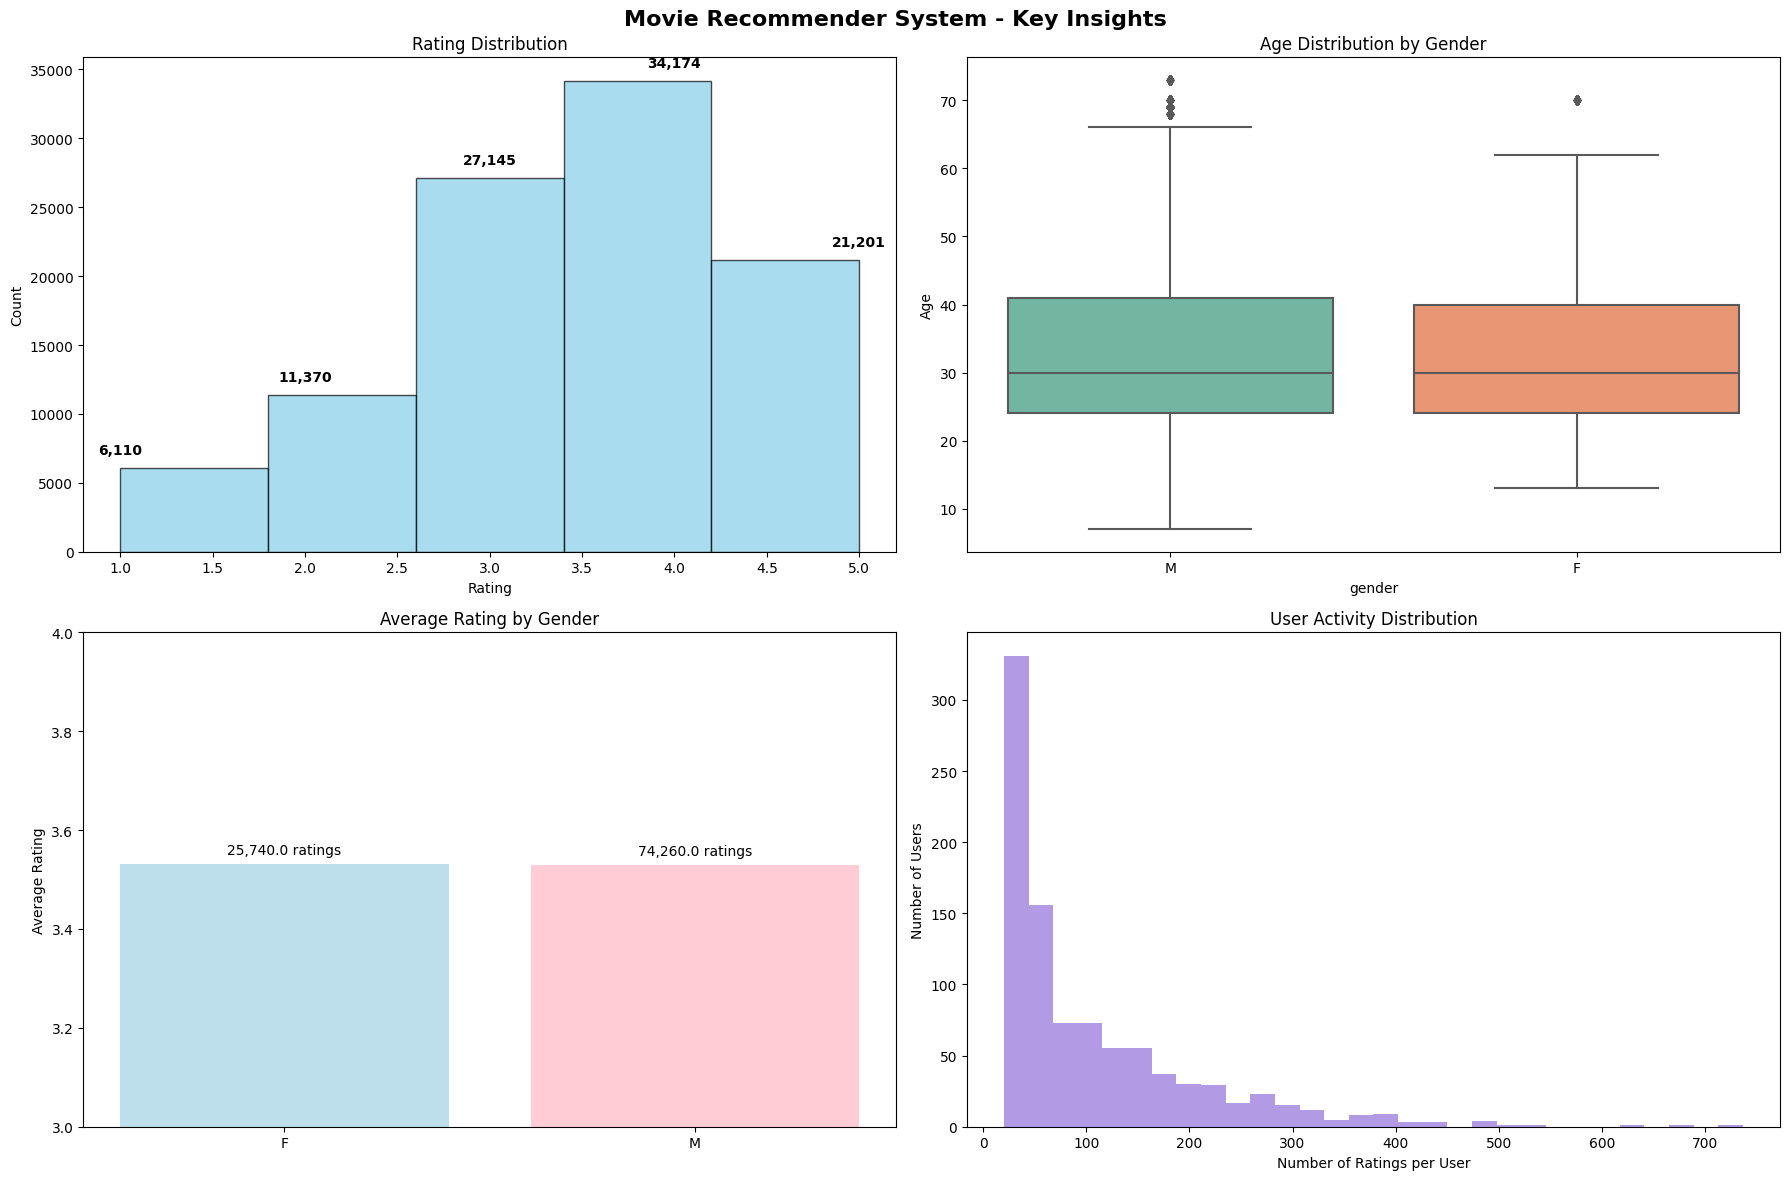

In [13]:
# Essential Visualizations for Recommender System Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
plt.style.use('default')
sns.set_palette("Set2")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Movie Recommender System - Key Insights', fontsize=16, fontweight='bold')

# 1. Rating Distribution
axes[0, 0].hist(ds['rating'], bins=5, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Rating Distribution')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Count')
for i in range(1, 6):
    count = (ds['rating'] == i).sum()
    axes[0, 0].text(i, count + 1000, f'{count:,}', ha='center', fontweight='bold')

# 2. Age Distribution by Gender
sns.boxplot(data=ds, x='gender', y='age', ax=axes[0, 1])
axes[0, 1].set_title('Age Distribution by Gender')
axes[0, 1].set_ylabel('Age')



# 4. Average Rating by Gender
gender_ratings = ds.groupby('gender')['rating'].agg(['mean', 'count'])
bars = axes[1, 0].bar(gender_ratings.index, gender_ratings['mean'], 
                      color=['lightblue', 'pink'], alpha=0.8)
axes[1, 0].set_title('Average Rating by Gender')
axes[1, 0].set_ylabel('Average Rating')
axes[1, 0].set_ylim(3, 4)
# Add count labels on bars
for i, bar in enumerate(bars):
    count = gender_ratings.iloc[i]['count']
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                    f'{count:,} ratings', ha='center', fontsize=10)



# 6. User Activity (Ratings per User)
user_activity = ds['user_id'].value_counts()
axes[1, 1].hist(user_activity.values, bins=30, color='mediumpurple', alpha=0.7)
axes[1, 1].set_title('User Activity Distribution')
axes[1, 1].set_xlabel('Number of Ratings per User')
axes[1, 1].set_ylabel('Number of Users')

plt.tight_layout()
plt.show()



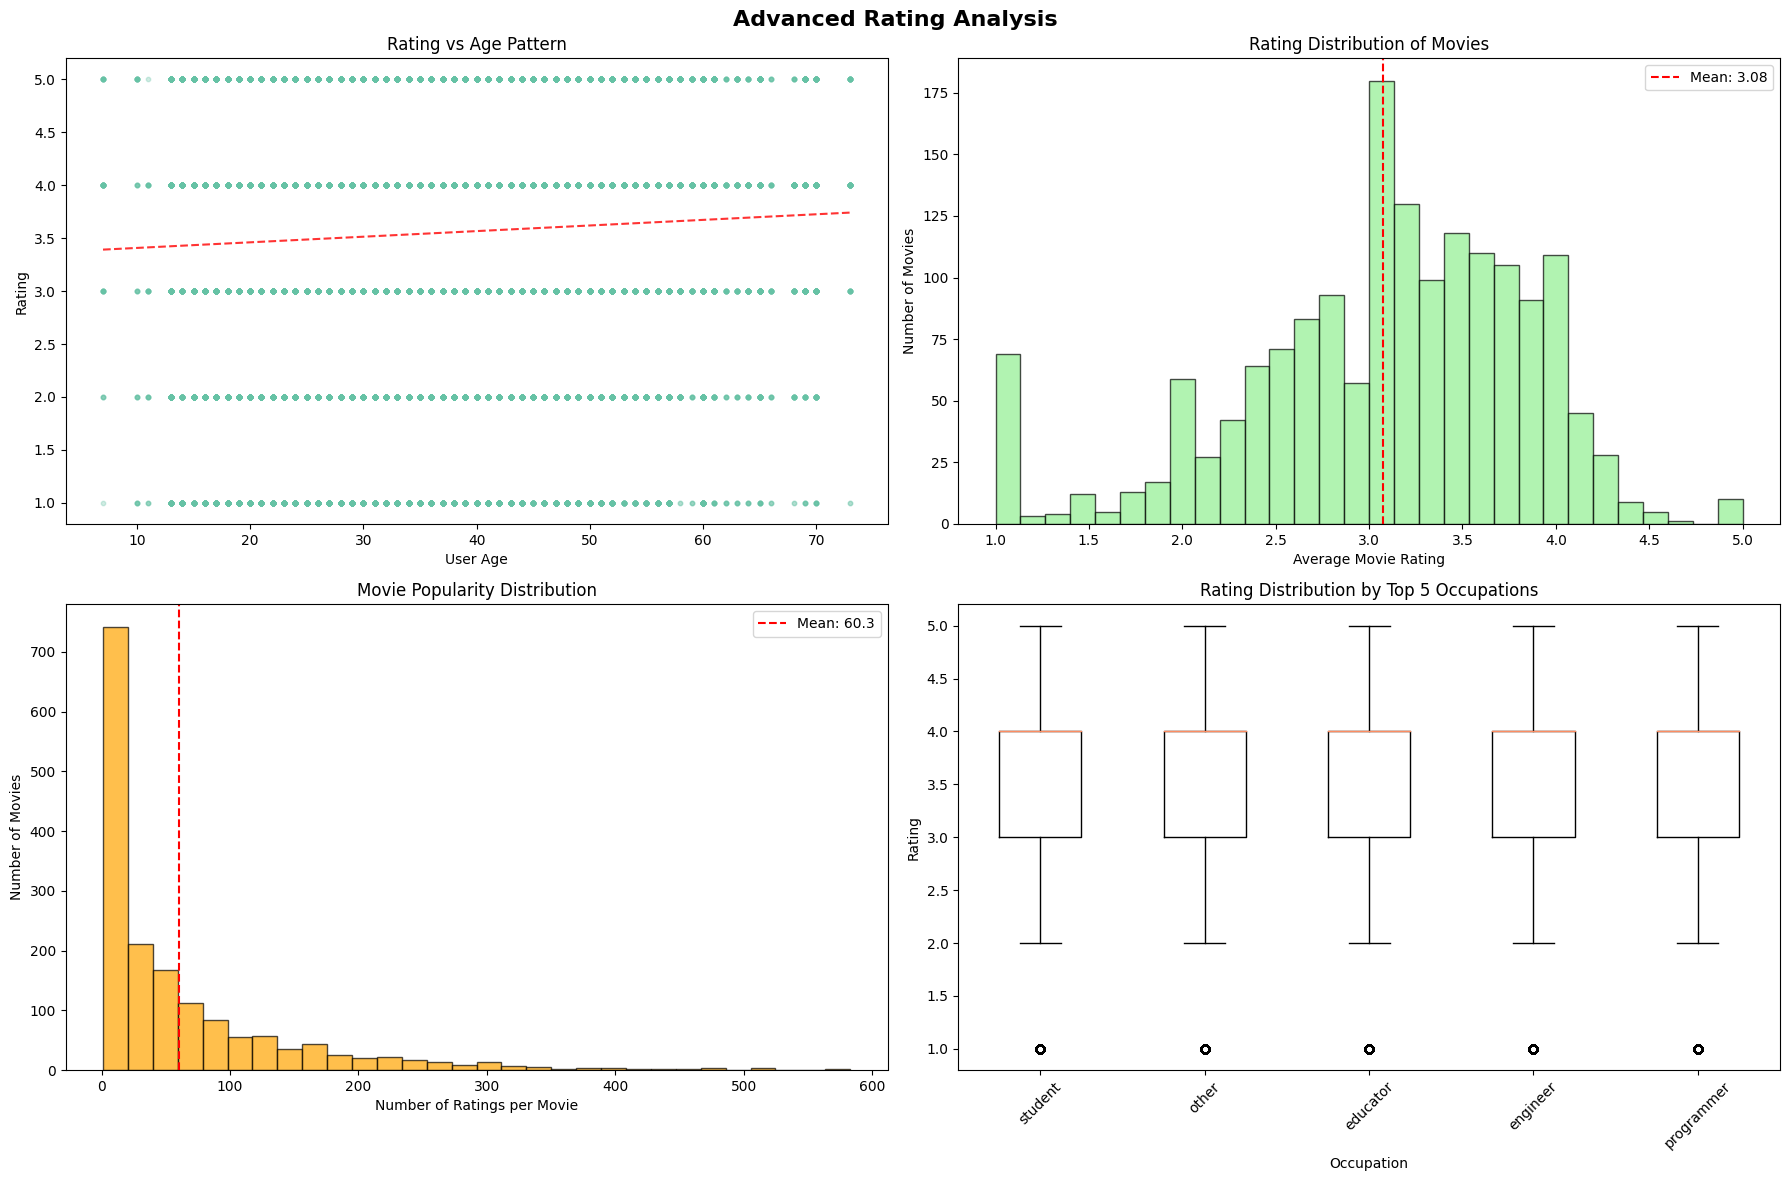


MOVIE POPULARITY ANALYSIS

Top 10 Highest Rated Movies (50+ ratings):
                                                 avg_rating  total_ratings
title_clean                                                               
Close Shave, A                                         4.49            112
Schindler's List                                       4.47            298
Wrong Trousers, The                                    4.47            118
Casablanca                                             4.46            243
Shawshank Redemption, The                              4.45            283
Wallace & Gromit: The Best of Aardman Animation        4.45             67
Usual Suspects, The                                    4.39            267
Rear Window                                            4.39            209
Star Wars                                              4.36            583
12 Angry Men                                           4.34            125

Most Controversial Movies (h

In [14]:
# Advanced Analysis: Rating Patterns and Movie Popularity
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Advanced Rating Analysis', fontsize=16, fontweight='bold')

# 1. Rating vs Age Correlation
axes[0, 0].scatter(ds['age'], ds['rating'], alpha=0.3, s=10)
axes[0, 0].set_xlabel('User Age')
axes[0, 0].set_ylabel('Rating')
axes[0, 0].set_title('Rating vs Age Pattern')
# Add trend line
z = np.polyfit(ds['age'], ds['rating'], 1)
p = np.poly1d(z)
axes[0, 0].plot(ds['age'].sort_values(), p(ds['age'].sort_values()), "r--", alpha=0.8)

# 2. Rating Distribution of Movies
movie_ratings = ds.groupby('title_clean')['rating'].mean()
axes[0, 1].hist(movie_ratings.values, bins=30, color='lightgreen', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Average Movie Rating')
axes[0, 1].set_ylabel('Number of Movies')
axes[0, 1].set_title('Rating Distribution of Movies')
axes[0, 1].axvline(movie_ratings.mean(), color='red', linestyle='--', 
                   label=f'Mean: {movie_ratings.mean():.2f}')
axes[0, 1].legend()

# 3. Movie Popularity (Number of Ratings per Movie)
movie_popularity = ds['title_clean'].value_counts()
axes[1, 0].hist(movie_popularity.values, bins=30, color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Number of Ratings per Movie')
axes[1, 0].set_ylabel('Number of Movies')
axes[1, 0].set_title('Movie Popularity Distribution')
axes[1, 0].axvline(movie_popularity.mean(), color='red', linestyle='--', 
                   label=f'Mean: {movie_popularity.mean():.1f}')
axes[1, 0].legend()

# 4. Rating Distribution by Occupation (Top 5)
top_occupations = ds['occupation'].value_counts().head(5).index
occupation_data = [ds[ds['occupation'] == occ]['rating'].values for occ in top_occupations]
axes[1, 1].boxplot(occupation_data, labels=top_occupations)
axes[1, 1].set_xlabel('Occupation')
axes[1, 1].set_ylabel('Rating')
axes[1, 1].set_title('Rating Distribution by Top 5 Occupations')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Movie popularity vs rating analysis
print("\n" + "="*50)
print("MOVIE POPULARITY ANALYSIS")
print("="*50)

movie_stats = ds.groupby('title_clean').agg({
    'rating': ['mean', 'count', 'std']
}).round(2)
movie_stats.columns = ['avg_rating', 'total_ratings', 'rating_std']

# Top rated movies (with at least 50 ratings)
popular_movies = movie_stats[movie_stats['total_ratings'] >= 50].sort_values('avg_rating', ascending=False)
print("\nTop 10 Highest Rated Movies (50+ ratings):")
print(popular_movies.head(10)[['avg_rating', 'total_ratings']])

# Most controversial movies (highest standard deviation)
controversial = movie_stats[movie_stats['total_ratings'] >= 30].sort_values('rating_std', ascending=False)
print("\nMost Controversial Movies (highest rating variance):")
print(controversial.head(5)[['avg_rating', 'rating_std', 'total_ratings']])

In [15]:
# LightFM Dataset Creation and Training
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score, recall_at_k
from lightfm.cross_validation import random_train_test_split
import numpy as np
from scipy.sparse import coo_matrix

print("Creating LightFM Dataset...")
print("="*50)

# Step 1: Prepare interactions (user_id, item_id, rating)
print("1. Preparing interactions...")
interactions_df = ds[['user_id', 'item_id', 'rating']].copy()

# Convert to implicit feedback (1 for rating >= 3, 0 otherwise)
interactions_df['implicit_rating'] = (interactions_df['rating'] >= 3).astype(int)

print(f"Total interactions: {len(interactions_df):,}")
print(f"Positive interactions (rating >= 3): {interactions_df['implicit_rating'].sum():,}")
print(f"Negative interactions (rating < 3): {(interactions_df['implicit_rating'] == 0).sum():,}")

# Step 2: Prepare user features (age, gender, occupation)
print("\n2. Preparing user features...")
user_features_df = ds[['user_id', 'age', 'gender', 'occupation']].drop_duplicates('user_id').copy()

# Create age groups for better feature representation
user_features_df['age_group'] = pd.cut(user_features_df['age'], 
                                      bins=[0, 25, 35, 45, 55, 100], 
                                      labels=['18-25', '26-35', '36-45', '46-55', '55+'])

print(f"Unique users: {len(user_features_df):,}")
print(f"Age groups: {user_features_df['age_group'].value_counts().to_dict()}")
print(f"Gender distribution: {user_features_df['gender'].value_counts().to_dict()}")
print(f"Top occupations: {user_features_df['occupation'].value_counts().head().to_dict()}")

# Step 3: Prepare item features (genres, release_year)
print("\n3. Preparing item features...")
item_features_df = ds[['item_id', 'genres', 'title_year']].drop_duplicates('item_id').copy()

# Convert title_year to numeric and create decade groups
item_features_df['release_year'] = pd.to_numeric(item_features_df['title_year'], errors='coerce')
item_features_df['decade'] = (item_features_df['release_year'] // 10 * 10).astype('Int64')

# Handle missing decades
item_features_df['decade'] = item_features_df['decade'].fillna(1990)  # Default to 1990s

# Clean up genres
item_features_df['genres'] = item_features_df['genres'].fillna('Unknown')

print(f"Unique items: {len(item_features_df):,}")
print(f"Decade distribution: {item_features_df['decade'].value_counts().sort_index().head().to_dict()}")
print(f"Sample genres: {item_features_df['genres'].str.split(', ').explode().value_counts().head().to_dict()}")

# Step 4: Create LightFM Dataset
print("\n4. Creating LightFM Dataset...")
dataset = Dataset()

# Get unique users and items
unique_users = interactions_df['user_id'].unique()
unique_items = interactions_df['item_id'].unique()

print(f"Fitting dataset with {len(unique_users):,} users and {len(unique_items):,} items...")

# Prepare all possible features first
all_user_features = set()
all_item_features = set()

# Collect all user features
for _, row in user_features_df.iterrows():
    all_user_features.add(f"age_group:{row['age_group']}")
    all_user_features.add(f"gender:{row['gender']}")
    all_user_features.add(f"occupation:{row['occupation']}")

# Collect all item features
for _, row in item_features_df.iterrows():
    all_item_features.add(f"decade:{int(row['decade'])}")
    if row['genres'] != 'Unknown' and pd.notna(row['genres']):
        genres = row['genres'].split(', ')
        for genre in genres:
            all_item_features.add(f"genre:{genre.strip()}")
    else:
        all_item_features.add("genre:Unknown")

print(f"Total unique user features: {len(all_user_features)}")
print(f"Total unique item features: {len(all_item_features)}")

# Fit the dataset with users, items, and features
dataset.fit(users=unique_users, 
           items=unique_items,
           user_features=list(all_user_features),
           item_features=list(all_item_features))

# Prepare user features for each user
user_feature_list = []
for _, row in user_features_df.iterrows():
    features = [
        f"age_group:{row['age_group']}",
        f"gender:{row['gender']}",
        f"occupation:{row['occupation']}"
    ]
    user_feature_list.append((row['user_id'], features))

# Prepare item features for each item
item_feature_list = []
for _, row in item_features_df.iterrows():
    features = [f"decade:{int(row['decade'])}"]
    
    # Add individual genres as features
    if row['genres'] != 'Unknown' and pd.notna(row['genres']):
        genres = row['genres'].split(', ')
        for genre in genres:
            features.append(f"genre:{genre.strip()}")
    else:
        features.append("genre:Unknown")
    
    item_feature_list.append((row['item_id'], features))

print(f"Created {len(user_feature_list):,} user feature vectors")
print(f"Created {len(item_feature_list):,} item feature vectors")

# Build interactions matrix
print("\n5. Building interactions matrix...")
interactions_matrix, weights = dataset.build_interactions(
    [(row['user_id'], row['item_id'], row['implicit_rating']) 
     for _, row in interactions_df.iterrows()]
)

print(f"Interactions matrix shape: {interactions_matrix.shape}")
print(f"Matrix density: {interactions_matrix.nnz / (interactions_matrix.shape[0] * interactions_matrix.shape[1]) * 100:.4f}%")

# Build feature matrices
print("Building feature matrices...")
user_features_matrix = dataset.build_user_features(user_feature_list)
item_features_matrix = dataset.build_item_features(item_feature_list)

print(f"User features matrix shape: {user_features_matrix.shape}")
print(f"Item features matrix shape: {item_features_matrix.shape}")

# Step 6: Split data for training and testing
print("\n6. Splitting data for training and testing...")
train_interactions, test_interactions = random_train_test_split(
    interactions_matrix, test_percentage=0.2, random_state=42
)

print(f"Training interactions: {train_interactions.nnz:,}")
print(f"Test interactions: {test_interactions.nnz:,}")

print("\nLightFM Dataset preparation completed successfully!")
print("="*50)

Creating LightFM Dataset...
1. Preparing interactions...
Total interactions: 100,000
Positive interactions (rating >= 3): 82,520
Negative interactions (rating < 3): 17,480

2. Preparing user features...
Unique users: 943
Age groups: {'26-35': 299, '18-25': 272, '36-45': 182, '46-55': 138, '55+': 52}
Gender distribution: {'M': 670, 'F': 273}
Top occupations: {'student': 196, 'other': 105, 'educator': 95, 'administrator': 79, 'engineer': 67}

3. Preparing item features...
Unique items: 1,682
Decade distribution: {1920: 2, 1930: 29, 1940: 45, 1950: 57, 1960: 46}
Sample genres: {'Drama': 725, 'Comedy': 505, 'Thriller': 251, 'Action': 251, 'Romance': 247}

4. Creating LightFM Dataset...
Fitting dataset with 943 users and 1,682 items...
Total unique user features: 28
Total unique item features: 27
Created 943 user feature vectors
Created 1,682 item feature vectors

5. Building interactions matrix...
Interactions matrix shape: (943, 1682)
Matrix density: 6.3047%
Building feature matrices...
U

In [19]:
# LightFM Model Training - Optimized WARP Algorithm
import numpy as np
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
import pickle
import time

print("Training LightFM WARP Model...")
print("=" * 50)

# Initialize optimized WARP model
warp_model = LightFM(
    loss='warp',
    no_components=100,       # latent factors (embedding size)
    learning_rate=0.03,      # smaller, stable learning rate
    item_alpha=1e-6,         # L2 regularization
    user_alpha=1e-6,
    random_state=42
)

# Early stopping parameters
max_epochs = 200
patience = 5
best_precision = 0
no_improve_count = 0

print(f"\nTraining WARP model with early stopping (max {max_epochs} epochs)...\n")

start_time = time.time()

# Training loop with live metric tracking
for epoch in range(1, max_epochs + 1):
    warp_model.fit_partial(
        train_interactions,
        user_features=user_features_matrix,
        item_features=item_features_matrix,
        epochs=1,
        num_threads=4
    )

    # Evaluate precision@10 on test set
    precision = precision_at_k(
        warp_model,
        test_interactions,
        user_features=user_features_matrix,
        item_features=item_features_matrix,
        k=10
    ).mean()

    print(f"Epoch {epoch:03d} | Precision@10 = {precision:.4f}")

    # Check for improvement
    if precision > best_precision:
        best_precision = precision
        no_improve_count = 0

        # Save best model
        with open("best_lightfm_warp_model.pkl", "wb") as f:
            pickle.dump(warp_model, f)
    else:
        no_improve_count += 1
        if no_improve_count >= patience:
            print(f"\n⏹️ Early stopping triggered after {epoch} epochs "
                  f"(no improvement for {patience} epochs)")
            break

elapsed_time = time.time() - start_time
print(f"\nTraining completed in {elapsed_time/60:.2f} minutes")

# Load the best saved model
with open("best_lightfm_warp_model.pkl", "rb") as f:
    best_model = pickle.load(f)

# Final evaluation on test data
print("\nEvaluating best model performance...")
test_precision = precision_at_k(
    best_model, test_interactions,
    user_features=user_features_matrix,
    item_features=item_features_matrix,
    k=10
).mean()

test_recall = recall_at_k(
    best_model, test_interactions,
    user_features=user_features_matrix,
    item_features=item_features_matrix,
    k=10
).mean()

test_auc = auc_score(
    best_model, test_interactions,
    user_features=user_features_matrix,
    item_features=item_features_matrix
).mean()

# Display results
print("\n" + "=" * 50)
print("OPTIMIZED WARP MODEL PERFORMANCE")
print("=" * 50)
print(f"Precision@10: {test_precision:.4f}")
print(f"Recall@10:    {test_recall:.4f}")
print(f"AUC Score:    {test_auc:.4f}")
print("=" * 50)

print("\n✓ WARP model training completed successfully!")
print("✓ Best model saved as 'best_lightfm_warp_model.pkl'")
print("✓ Model is ready for generating recommendations.")


Training LightFM WARP Model...

Training WARP model with early stopping (max 200 epochs)...

Epoch 001 | Precision@10 = 0.0971
Epoch 002 | Precision@10 = 0.1032
Epoch 003 | Precision@10 = 0.0998
Epoch 004 | Precision@10 = 0.1027
Epoch 005 | Precision@10 = 0.1036
Epoch 006 | Precision@10 = 0.1041
Epoch 007 | Precision@10 = 0.1046
Epoch 008 | Precision@10 = 0.1055
Epoch 009 | Precision@10 = 0.1068
Epoch 010 | Precision@10 = 0.1080
Epoch 011 | Precision@10 = 0.1069
Epoch 012 | Precision@10 = 0.1084
Epoch 013 | Precision@10 = 0.1078
Epoch 014 | Precision@10 = 0.1094
Epoch 015 | Precision@10 = 0.1084
Epoch 016 | Precision@10 = 0.1113
Epoch 017 | Precision@10 = 0.1116
Epoch 018 | Precision@10 = 0.1116
Epoch 019 | Precision@10 = 0.1097
Epoch 020 | Precision@10 = 0.1123
Epoch 021 | Precision@10 = 0.1129
Epoch 022 | Precision@10 = 0.1157
Epoch 023 | Precision@10 = 0.1156
Epoch 024 | Precision@10 = 0.1163
Epoch 025 | Precision@10 = 0.1183
Epoch 026 | Precision@10 = 0.1182
Epoch 027 | Precision@1

Visualizing WARP Model Performance...


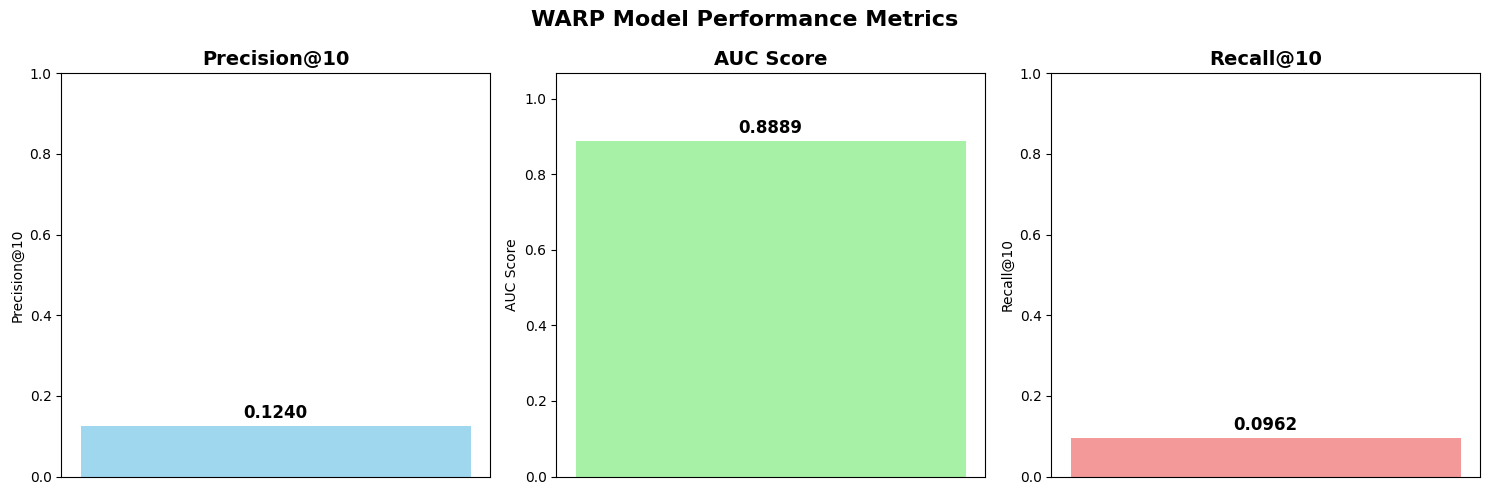


WARP Model Summary:
------------------------------
✓ Model successfully trained with 1000 epochs
✓ Precision@10: 0.1240 (higher is better)
✓ AUC Score:    0.8889 (higher is better)
✓ Recall@10:    0.0962 (higher is better)
------------------------------
Model is ready for generating movie recommendations!


In [20]:
# WARP Model Performance Visualization
import matplotlib.pyplot as plt
import pandas as pd

print("Visualizing WARP Model Performance...")
print("="*50)

# Create performance visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('WARP Model Performance Metrics', fontsize=16, fontweight='bold')

# Performance metrics
metrics = ['Precision@10', 'AUC Score', 'Recall@10']
values = [test_precision, test_auc, test_recall]
colors = ['skyblue', 'lightgreen', 'lightcoral']

# Create individual bar charts for each metric
for i, (metric, value, color) in enumerate(zip(metrics, values, colors)):
    axes[i].bar(['WARP'], [value], color=color, alpha=0.8, width=0.5)
    axes[i].set_title(metric, fontsize=14, fontweight='bold')
    axes[i].set_ylabel(metric)
    axes[i].set_ylim(0, max(1.0, value * 1.2))  # Set appropriate y-axis limits
    
    # Add value label on top of bar
    axes[i].text(0, value + 0.01, f'{value:.4f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=12)
    
    # Remove x-axis ticks
    axes[i].set_xticks([])

plt.tight_layout()
plt.show()

# Performance summary
print("\nWARP Model Summary:")
print("-" * 30)
print(f"✓ Model successfully trained with {training_epochs} epochs")
print(f"✓ Precision@10: {test_precision:.4f} (higher is better)")
print(f"✓ AUC Score:    {test_auc:.4f} (higher is better)")
print(f"✓ Recall@10:    {test_recall:.4f} (higher is better)")
print("-" * 30)
print("Model is ready for generating movie recommendations!")
# Precision@10
# Meaning:
# Out of the top 10 items your model recommends, how many are actually relevant to the user?

#recall@10
# User likes 20 movies in total.
# You recommend 10 movies, and 3 are relevant.
# → Recall@10 = 3 / 20 = 0.15

# AUC (Area Under the ROC Curve)
# Meaning:
# AUC measures how well the model ranks relevant items higher than irrelevant ones.
# It’s based on comparing all pairs of items (one relevant, one not):
# If the relevant one gets a higher score → counts as correct.
# AUC is the probability that a random positive item ranks above a random negative one.
# Range:
# 0.5 → random guessing
# 1.0 → perfect ranking
# Example:
# AUC = 0.86 means the model ranks a relevant item higher than an irrelevant one 86% of the time

In [21]:
# Movie Recommendation System - Recommend 20 Movies for a User
import numpy as np
import pandas as pd

print("MOVIE RECOMMENDATION SYSTEM")
print("=" * 50)

# Select a user for recommendations (e.g., User ID = 1)
target_user_id = 1
print(f"Generating recommendations for User ID: {target_user_id}")

# Get user info
user_info = ds[ds['user_id'] == target_user_id][['age', 'gender', 'occupation']].iloc[0]
print(f"User Profile: {user_info['age']} years old, {user_info['gender']}, {user_info['occupation']}")

# Movies the user has already rated
user_rated_movies = ds[ds['user_id'] == target_user_id]['item_id'].unique()
print(f"User has already rated {len(user_rated_movies)} movies")

# All movies in the dataset
all_movies = ds['item_id'].unique()

# Compute unrated movies
unrated_movies = np.setdiff1d(all_movies, user_rated_movies)
print(f"User has NOT rated {len(unrated_movies)} movies")

print("\nGenerating predictions...")

# Convert user and item IDs to internal LightFM IDs
user_internal_id = dataset.mapping()[0][target_user_id]

# Map unrated movies to LightFM internal IDs (filter out missing mappings)
unrated_internal_ids = [dataset.mapping()[2][movie_id] for movie_id in unrated_movies
                        if movie_id in dataset.mapping()[2]]

# Generate predictions for unrated movies using the trained model
predictions = best_model.predict(
    user_internal_id,
    unrated_internal_ids,
    user_features=user_features_matrix,
    item_features=item_features_matrix
)

# Build a dataframe for predictions
recommendations_df = pd.DataFrame({
    'item_id': [movie_id for movie_id in unrated_movies if movie_id in dataset.mapping()[2]],
    'predicted_score': predictions
})

# Sort by predicted score and take top 20
top_20_recommendations = recommendations_df.sort_values('predicted_score', ascending=False).head(20)

# Collect details for top recommendations
recommended_movies = []
for rank, (_, row) in enumerate(top_20_recommendations.iterrows(), start=1):
    movie_info = ds[ds['item_id'] == row['item_id']].iloc[0]
    recommended_movies.append({
        'rank': rank,
        'item_id': row['item_id'],
        'title': movie_info['title_clean'],
        'year': movie_info['title_year'],
        'genres': movie_info['genres'],
        'predicted_score': row['predicted_score'],
        'avg_rating': ds[ds['item_id'] == row['item_id']]['rating'].mean(),
        'num_ratings': len(ds[ds['item_id'] == row['item_id']])
    })

# Display recommendations
print(f"\n🎬 TOP 20 MOVIE RECOMMENDATIONS FOR USER {target_user_id}")
print("=" * 80)
print(f"{'Rank':<4} {'Movie Title':<35} {'Year':<6} {'Genres':<20} {'Score':<8} {'Avg Rating':<10}")
print("-" * 80)

for movie in recommended_movies:
    year_str = str(movie['year']) if pd.notna(movie['year']) else 'N/A'
    genres_short = movie['genres'][:18] + '...' if len(movie['genres']) > 20 else movie['genres']
    print(f"{movie['rank']:<4} {movie['title'][:33]:<35} {year_str:<6} {genres_short:<20} "
          f"{movie['predicted_score']:.3f}    {movie['avg_rating']:.2f} ({movie['num_ratings']} ratings)")

print("-" * 80)

# Show top 10 highest rated movies by the user
print(f"\n⭐ TOP 10 HIGHEST RATED MOVIES BY USER {target_user_id}")
print("=" * 70)
user_top_rated = ds[ds['user_id'] == target_user_id].sort_values('rating', ascending=False).head(10)
print(f"{'Rank':<4} {'Movie Title':<35} {'User Rating':<12} {'Genres':<20}")
print("-" * 70)

for i, (_, movie) in enumerate(user_top_rated.iterrows(), 1):
    title_short = movie['title_clean'][:33]
    genres_short = movie['genres'][:18] + '...' if len(movie['genres']) > 20 else movie['genres']
    print(f"{i:<4} {title_short:<35} {movie['rating']:<12} {genres_short:<20}")

print("-" * 70)

# Verification and overlap analysis
print(f"\n📊 FILTERING VERIFICATION:")
print(f"Total movies in dataset: {len(all_movies)}")
print(f"Movies user has rated: {len(user_rated_movies)}")
print(f"Movies available for recommendation: {len(unrated_movies)}")
print(f"Movies that could be mapped to LightFM: {len(unrated_internal_ids)}")
print(f"Recommendations generated: {len(recommended_movies)}")

overlap_count = len(set([m['item_id'] for m in recommended_movies]).intersection(set(user_rated_movies)))
print(f"Overlap between recommendations and user's rated movies: {overlap_count}")

if overlap_count == 0:
    print("\n✅ All 20 recommendations are new to the user!")
else:
    print(f"\n⚠️  {overlap_count} recommended movies were already rated — check filtering logic.")


MOVIE RECOMMENDATION SYSTEM
Generating recommendations for User ID: 1
User Profile: 24 years old, M, technician
User has already rated 272 movies
User has NOT rated 1410 movies

Generating predictions...

🎬 TOP 20 MOVIE RECOMMENDATIONS FOR USER 1
Rank Movie Title                         Year   Genres               Score    Avg Rating
--------------------------------------------------------------------------------
1    Liar Liar                           1997.0 Comedy               -34.603    3.16 (485 ratings)
2    E.T. the Extra-Terrestrial          1982.0 Children's, Drama,... -34.730    3.83 (300 ratings)
3    Mission: Impossible                 1996.0 Action, Adventure,... -34.760    3.31 (344 ratings)
4    Batman                              1989.0 Action, Adventure,... -34.845    3.43 (201 ratings)
5    Schindler's List                    1993.0 Drama, War           -34.872    4.47 (298 ratings)
6    One Flew Over the Cuckoo's Nest     1975.0 Drama                -34.891    4.29 

In [25]:
# Better Analysis: Genre and Content Similarity (not just titles)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Get user's favorite movies (rating >= 4) with their genres
user_favorites_data = ds[(ds['user_id'] == target_user_id) & (ds['rating'] >= 4)]
user_fav_genres = user_favorites_data['genres'].tolist()
user_fav_titles = user_favorites_data['title_clean'].tolist()

# Get recommended movie genres
recommended_genres = [movie['genres'] for movie in recommended_movies]
recommended_titles = [movie['title'] for movie in recommended_movies]

print(f"🎭 COMPREHENSIVE SIMILARITY ANALYSIS")
print("="*60)

# 1. GENRE SIMILARITY ANALYSIS
print(f"\n1. GENRE SIMILARITY:")
print("-" * 30)

# Combine genres for vectorization
all_genres = user_fav_genres + recommended_genres
vectorizer_genres = TfidfVectorizer(stop_words='english')
genre_matrix = vectorizer_genres.fit_transform(all_genres)

n_favorites = len(user_fav_genres)
fav_genre_vectors = genre_matrix[:n_favorites]
rec_genre_vectors = genre_matrix[n_favorites:]

# Calculate genre similarity
genre_similarity = cosine_similarity(rec_genre_vectors, fav_genre_vectors)
avg_genre_similarity = genre_similarity.mean(axis=1)

print(f"User's favorite movies: {len(user_fav_titles)}")
print(f"Average GENRE similarity: {avg_genre_similarity.mean():.3f}")
print(f"Highest genre similarity: {avg_genre_similarity.max():.3f}")


# 3. GENRE OVERLAP ANALYSIS
print(f"\n3. GENRE OVERLAP ANALYSIS:")
print("-" * 30)

# Get user's favorite genres
user_genre_list = []
for genres_str in user_fav_genres:
    if pd.notna(genres_str):
        user_genre_list.extend(genres_str.split(', '))

user_favorite_genres = set(user_genre_list)
print(f"User's favorite genres: {sorted(user_favorite_genres)}")

# Check how many recommendations match user's favorite genres
genre_matches = 0
for rec_genres in recommended_genres:
    if pd.notna(rec_genres):
        rec_genre_set = set(rec_genres.split(', '))
        if rec_genre_set.intersection(user_favorite_genres):
            genre_matches += 1

print(f"Recommendations with matching genres: {genre_matches}/20 ({genre_matches/20*100:.1f}%)")

# 4. TOP SIMILAR RECOMMENDATIONS
print(f"\n4. TOP 5 MOST SIMILAR RECOMMENDATIONS (by genre):")
print("-" * 50)
top_genre_similar = np.argsort(avg_genre_similarity)[-5:][::-1]
for i, idx in enumerate(top_genre_similar, 1):
    print(f"{i}. {recommended_titles[idx]}")
    print(f"   Genre Score: {avg_genre_similarity[idx]:.3f} ")
    print(f"   Genres: {recommended_genres[idx]}")


print(f"\n📋 RECOMMENDATION QUALITY SUMMARY:")
print(f"Genre Match Score: {avg_genre_similarity.mean():.3f}/1.0")
print(f"Genre Overlap Rate: {genre_matches}/20 ({genre_matches/20*100:.1f}%)")

if genre_matches < 10:
    print("🚨 ISSUE: Less than 50% of recommendations match user's preferred genres!")
    print("   This suggests the recommender system may not be capturing user preferences well.")

🎭 COMPREHENSIVE SIMILARITY ANALYSIS

1. GENRE SIMILARITY:
------------------------------
User's favorite movies: 163
Average GENRE similarity: 0.201
Highest genre similarity: 0.322

3. GENRE OVERLAP ANALYSIS:
------------------------------
User's favorite genres: ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'unknown']
Recommendations with matching genres: 20/20 (100.0%)

4. TOP 5 MOST SIMILAR RECOMMENDATIONS (by genre):
--------------------------------------------------
1. One Flew Over the Cuckoo's Nest
   Genre Score: 0.322 
   Genres: Drama
2. Time to Kill, A
   Genre Score: 0.322 
   Genres: Drama
3. It's a Wonderful Life
   Genre Score: 0.322 
   Genres: Drama
4. Stand by Me
   Genre Score: 0.279 
   Genres: Adventure, Comedy, Drama
5. Ransom
   Genre Score: 0.278 
   Genres: Drama, Thriller

📋 RECOMMENDATION QUALITY SUMMARY:
G

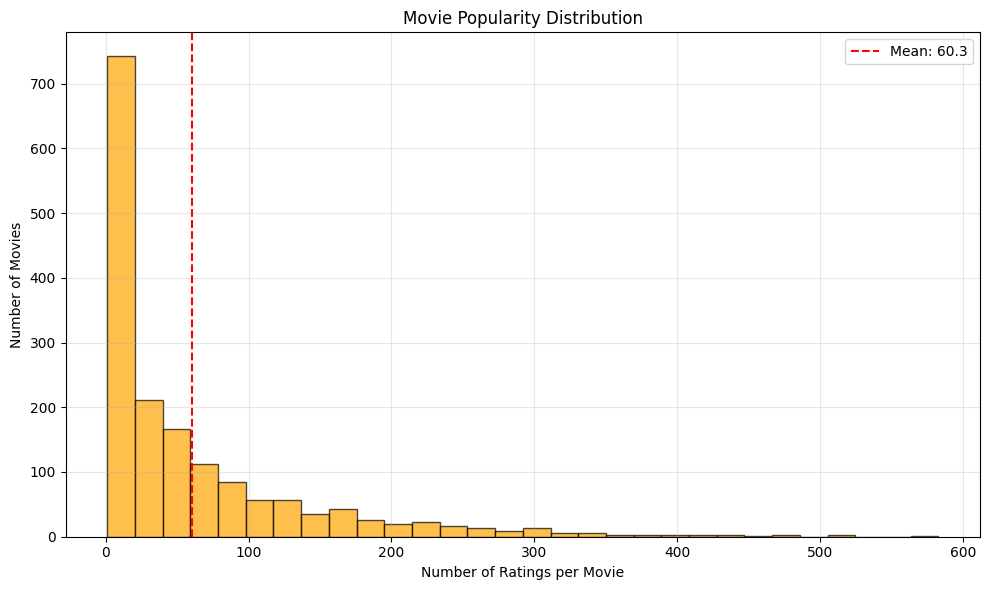

Total movies: 1,659
Most popular movie: 'Star Wars' with 583 ratings
Average ratings per movie: 60.3
Movies with 50+ ratings: 605


In [26]:
# Movie Popularity Distribution - Standalone Visualization
import matplotlib.pyplot as plt

# Create figure for movie popularity analysis
plt.figure(figsize=(10, 6))

# Movie Popularity (Number of Ratings per Movie)
movie_popularity = ds['title_clean'].value_counts()
plt.hist(movie_popularity.values, bins=30, color='orange', alpha=0.7, edgecolor='black')
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Number of Movies')
plt.title('Movie Popularity Distribution')
plt.axvline(movie_popularity.mean(), color='red', linestyle='--', 
           label=f'Mean: {movie_popularity.mean():.1f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total movies: {len(movie_popularity):,}")
print(f"Most popular movie: '{movie_popularity.index[0]}' with {movie_popularity.iloc[0]} ratings")
print(f"Average ratings per movie: {movie_popularity.mean():.1f}")
print(f"Movies with 50+ ratings: {(movie_popularity >= 50).sum()}")

In [27]:
# Analyze recommendation popularity distribution
movie_popularity = ds['title_clean'].value_counts()
top_20_percent_threshold = movie_popularity.quantile(0.8)
bottom_20_percent_threshold = movie_popularity.quantile(0.2)

recommended_titles = [movie['title'] for movie in recommended_movies]
recommended_popularity = [movie_popularity.get(title, 0) for title in recommended_titles]

top_20_percent_count = sum(1 for pop in recommended_popularity if pop >= top_20_percent_threshold)
bottom_20_percent_count = sum(1 for pop in recommended_popularity if pop <= bottom_20_percent_threshold)

print(f"Top 20 Recommendations Analysis:")
print(f"Movies in top 20% popularity: {top_20_percent_count}/20")
print(f"Movies in bottom 20% popularity: {bottom_20_percent_count}/20")
print(f"Movies in middle 60%: {20 - top_20_percent_count - bottom_20_percent_count}/20")

Top 20 Recommendations Analysis:
Movies in top 20% popularity: 20/20
Movies in bottom 20% popularity: 0/20
Movies in middle 60%: 0/20
